In [1]:
# Import the libraries

import pandas as pd 
import numpy as np

from pprint import pprint

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

import spacy

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.corpus import wordnet

import warnings
warnings.filterwarnings("ignore")


/Users/siriamanda/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/Users/siriamanda/opt/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


Code references:

https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/


In [2]:
df = pd.read_csv('/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/sentiment-analysis-of-reviews/01-sentiment-analysis/01-programming-for-everybody/VADER-programming-for-everybody.csv')

In [3]:
df.head()

,Unnamed: 0,date,review,rating,status,length,label,language_scores,language,scores,compound,sentiment
0,0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,"{'language': 'en', 'score': 0.9999988169641919}",en,"{'neg': 0.0, 'neu': 0.601, 'pos': 0.399, 'comp...",0.9062,pos
1,1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos,"{'language': 'en', 'score': 0.9999984011655625}",en,"{'neg': 0.0, 'neu': 0.453, 'pos': 0.547, 'comp...",0.9678,pos
2,2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67,pos,"{'language': 'en', 'score': 0.9999980645444568}",en,"{'neg': 0.0, 'neu': 0.746, 'pos': 0.254, 'comp...",0.4703,pos
3,3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166,pos,"{'language': 'en', 'score': 0.9999973332745635}",en,"{'neg': 0.0, 'neu': 0.553, 'pos': 0.447, 'comp...",0.9448,pos
4,4,2021-03-11,Perfect for new learners,5,completer,24,pos,"{'language': 'en', 'score': 0.9999967444537561}",en,"{'neg': 0.0, 'neu': 0.448, 'pos': 0.552, 'comp...",0.5719,pos


In [4]:
df.drop(['Unnamed: 0', 'language_scores', 'language', 'scores'], axis = 1, inplace = True)

In [5]:
df

,date,review,rating,status,length,label,compound,sentiment
0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,0.9062,pos
1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos,0.9678,pos
2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67,pos,0.4703,pos
3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166,pos,0.9448,pos
4,2021-03-11,Perfect for new learners,5,completer,24,pos,0.5719,pos
...,...,...,...,...,...,...,...,...
9558,2020-07-21,excellent explanation starting with how comput...,5,dropout,129,pos,0.9080,pos
9559,2020-07-21,My friend recommanded the lecture. It really d...,5,dropout,69,pos,0.5411,pos
9560,2020-07-21,Highly recommend this sets a good foundation ...,5,dropout,56,pos,0.6901,pos
9561,2020-07-21,best python programming course for absolute be...,5,dropout,53,pos,0.6369,pos


In [6]:
# Check for null values

len(df[df['review'].isna()==True])

0

In [7]:
# Drop null values

# df.dropna(inplace = True)

In [8]:
# Check for null values

# len(df[df['review'].isna()==True])

In [9]:
# Reset the index

# df = df.reset_index(drop = True)

In [10]:
# df

In [11]:
# Define a function to plot the most frequent words

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.xticks(rotation = 45)
    plt.show()

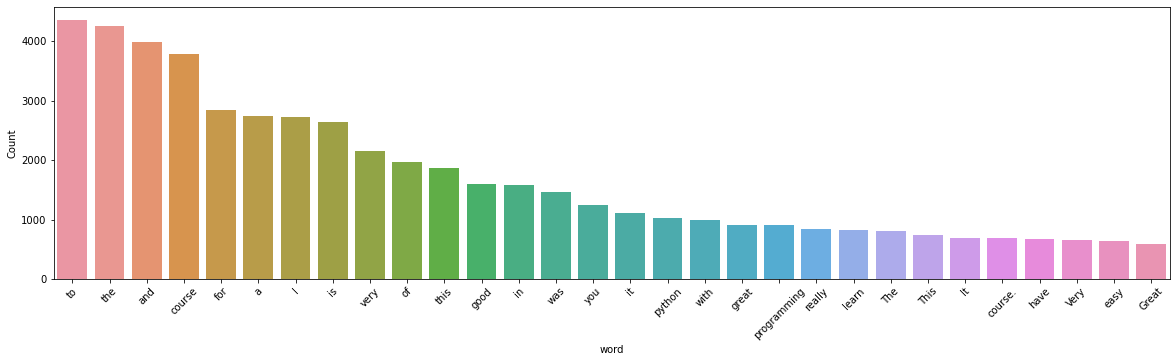

In [12]:
# The most frquent words are stop words such as 'to' and 'the' we will remove these in the preprocessing steps

freq_words(df['review'])

## Preprocessing

In [67]:
# Covert to lowercase

df['preprocessed'] =  df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['preprocessed'].head()

0    nice course for beginners where we can enjoy a...
1    super easy and totally for the beginners like ...
2    very interactive and a nice course to start pr...
3    awesome course! definitely a very nice introdu...
4                             perfect for new learners
Name: preprocessed, dtype: object

In [68]:
# Remove punctuations

df['preprocessed'] = df['preprocessed'].str.replace('[^\w\s]','')
df['preprocessed'].head()

0    nice course for beginners where we can enjoy a...
1    super easy and totally for the beginners like ...
2    very interactive and a nice course to start pr...
3    awesome course definitely a very nice introduc...
4                             perfect for new learners
Name: preprocessed, dtype: object

In [69]:
# Remove stopwords

stop = stopwords.words('english')
stop.extend(['good', 'great', 'really', 'like', 'nice', 'one', 'well', 'thank', 'love', 'im', 'get'])

df['preprocessed'] = df['preprocessed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['preprocessed'].head(10)

0    course beginners enjoy learn dr chuck made hug...
1    super easy totally beginners course title prof...
2          interactive course start programming pyhton
3    awesome course definitely introduction coding ...
4                                 perfect new learners
5    amazing course beginnersit beginner friendly c...
6                               course amazing teacher
7    challenging perfect course beginner python awe...
8                           programming using language
9                                            best best
Name: preprocessed, dtype: object

In [70]:
df[(df['preprocessed']== "")]

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined


In [71]:
df = df[(df['preprocessed']!= "")]

In [72]:
df[(df['preprocessed']== "")]

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined


In [73]:
# Build a model for creating bigrams

# bigram = gensim.models.Phrases(texts)

# df['preprocessed'] = [bigram[line] for line in df['preprocessed']]
# df['preprocessed'].head(5)

In [74]:
# Check for null values

# len(df[df['preprocessed'].isna()==True])

In [75]:
# Remove short words (length < 3)

# df['review'] = df['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
# df['review'].head()

In [76]:
# Join reviews

# df['joined'] = df['preprocessed'].apply(lambda x: ' '.join(x))

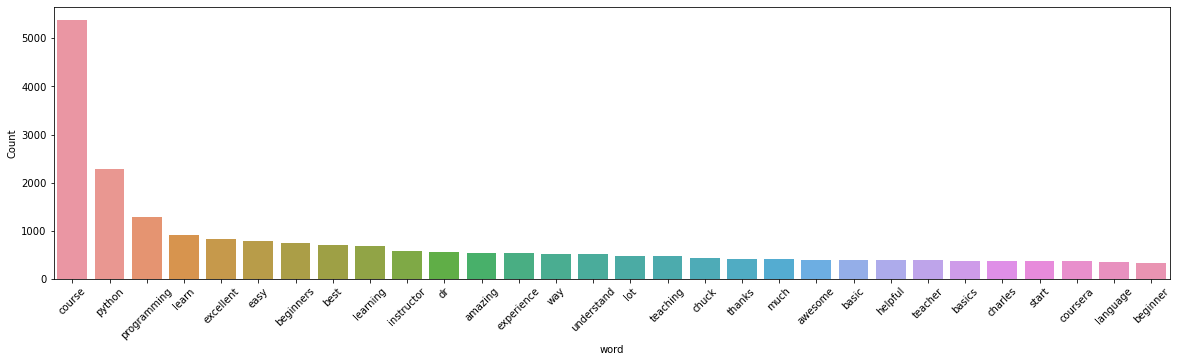

In [77]:
# Look at the most frequent words again 

freq_words(df['preprocessed'])

In [78]:
# Tokenization

tokenizer = RegexpTokenizer(r'\w+')

df['preprocessed'] = df['preprocessed'].apply(lambda x: tokenizer.tokenize(x.lower()))
df['preprocessed'].head(5)


0    [course, beginners, enjoy, learn, dr, chuck, m...
1    [super, easy, totally, beginners, course, titl...
2    [interactive, course, start, programming, pyhton]
3    [awesome, course, definitely, introduction, co...
4                             [perfect, new, learners]
Name: preprocessed, dtype: object

In [79]:
# Add speech tags

df['preprocessed'] = df['preprocessed'].apply(nltk.tag.pos_tag)
df['preprocessed'].head()

0    [(course, NN), (beginners, NNS), (enjoy, VBP),...
1    [(super, JJ), (easy, JJ), (totally, RB), (begi...
2    [(interactive, JJ), (course, NN), (start, NN),...
3    [(awesome, JJ), (course, NN), (definitely, RB)...
4          [(perfect, JJ), (new, JJ), (learners, NNS)]
Name: preprocessed, dtype: object

In [80]:
# Define function to convert parts of speech tags to wordnet’s format

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [81]:
# Apply the function to the tagged data

df['preprocessed'] = df['preprocessed'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df['preprocessed'].head()

0    [(course, n), (beginners, n), (enjoy, v), (lea...
1    [(super, a), (easy, a), (totally, r), (beginne...
2    [(interactive, a), (course, n), (start, n), (p...
3    [(awesome, a), (course, n), (definitely, r), (...
4              [(perfect, a), (new, a), (learners, n)]
Name: preprocessed, dtype: object

In [82]:
# Create lemmatizer

lemmatizer = WordNetLemmatizer()

# Apply to data 

df['preprocessed'] = df['preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word, tag) for word, tag in x])
df['preprocessed'].head()

0    [course, beginner, enjoy, learn, dr, chuck, ma...
1    [super, easy, totally, beginner, course, title...
2        [interactive, course, start, program, pyhton]
3    [awesome, course, definitely, introduction, co...
4                              [perfect, new, learner]
Name: preprocessed, dtype: object

In [83]:
# Join reviews

df['joined'] = df['preprocessed'].apply(lambda x: ' '.join(x))

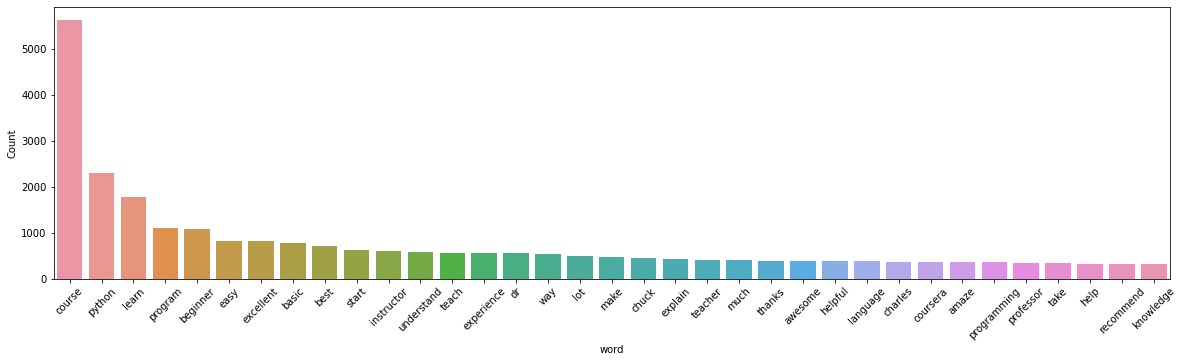

In [84]:
# Most frequent words after lemmatizing 

freq_words(df['joined'], 35)

In [85]:
# Reset the index

df = df.reset_index(drop = True)

In [86]:
df

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined
0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,0.9062,pos,"[course, beginner, enjoy, learn, dr, chuck, ma...",course beginner enjoy learn dr chuck make huge...
1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos,0.9678,pos,"[super, easy, totally, beginner, course, title...",super easy totally beginner course title profe...
2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67,pos,0.4703,pos,"[interactive, course, start, program, pyhton]",interactive course start program pyhton
3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166,pos,0.9448,pos,"[awesome, course, definitely, introduction, co...",awesome course definitely introduction cod wor...
4,2021-03-11,Perfect for new learners,5,completer,24,pos,0.5719,pos,"[perfect, new, learner]",perfect new learner
...,...,...,...,...,...,...,...,...,...,...
8827,2020-07-21,excellent explanation starting with how comput...,5,dropout,129,pos,0.9080,pos,"[excellent, explanation, start, computer, gene...",excellent explanation start computer general w...
8828,2020-07-21,My friend recommanded the lecture. It really d...,5,dropout,69,pos,0.5411,pos,"[friend, recommanded, lecture, deserve, five, ...",friend recommanded lecture deserve five star rate
8829,2020-07-21,Highly recommend this sets a good foundation ...,5,dropout,56,pos,0.6901,pos,"[highly, recommend, set, foundation, python]",highly recommend set foundation python
8830,2020-07-21,best python programming course for absolute be...,5,dropout,53,pos,0.6369,pos,"[best, python, program, course, absolute, begi...",best python program course absolute beginner


## LDA Topic Modeling

In [87]:
# Create a dictionary from 'df_sen['review']' containing the number of times a word appears in the training set

dictionary = gensim.corpora.Dictionary(df['preprocessed'])

In [88]:
# Gensim filter extremes

# Filter out tokens that appear in:
# Less than 50 documents, more than 0.5 documents, and keep only 100000 most frquent tokens

# dictionary.filter_extremes(no_below = 50, no_above = 0.5, keep_n = 100000)

In [89]:
# Gensim doc2bow
# Create a dictionary reporting how many words and how many times those words appear

corpus = [dictionary.doc2bow(doc) for doc in df['preprocessed']]


In [90]:
# Add TF-IDF

tfidf = models.TfidfModel(corpus)      # Create a TF-IDF model
corpus_tfidf = tfidf[corpus]  

In [91]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.LdaMulticore

# Build LDA model
lda_model = LDA(corpus = corpus, id2word = dictionary, num_topics = 6, random_state = 100,
                chunksize = 100, passes = 10, alpha = 0.31)

In [92]:
# Explore the words occurring in each topic and its relative weight

for id, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(id, topic))
    
print('Topic 0: Learning experience, Topic 1: Delivery style, Topic 2: Instructor skills, Topic 3: Content')

Topic: 0
Word: 0.053*"experience" + 0.050*"dr" + 0.044*"chuck" + 0.042*"learn" + 0.040*"course" + 0.024*"much" + 0.022*"enjoy" + 0.020*"knowledge" + 0.018*"lot" + 0.016*"sir"

Topic: 1
Word: 0.067*"course" + 0.049*"awesome" + 0.047*"coursera" + 0.046*"thanks" + 0.024*"charles" + 0.023*"wonderful" + 0.018*"amazing" + 0.017*"severance" + 0.014*"lot" + 0.013*"university"

Topic: 2
Word: 0.028*"assignment" + 0.018*"think" + 0.018*"work" + 0.017*"video" + 0.012*"time" + 0.012*"lecture" + 0.011*"quiz" + 0.011*"code" + 0.011*"week" + 0.010*"example"

Topic: 3
Word: 0.136*"python" + 0.078*"learn" + 0.070*"course" + 0.051*"program" + 0.048*"basic" + 0.039*"start" + 0.027*"understand" + 0.026*"language" + 0.024*"easy" + 0.022*"programming"

Topic: 4
Word: 0.045*"course" + 0.037*"easy" + 0.028*"make" + 0.024*"class" + 0.024*"recommend" + 0.019*"helpful" + 0.018*"clear" + 0.015*"instructor" + 0.015*"highly" + 0.014*"would"

Topic: 5
Word: 0.232*"course" + 0.086*"beginner" + 0.066*"excellent" + 0.0

### Visualise with pyLDAvis

Original paper: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [93]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.010561  0.252646       1        1  22.622203
4     -0.054026  0.039421       2        1  18.186273
5      0.181574 -0.021897       3        1  16.611862
0      0.062320  0.024938       4        1  15.747772
2     -0.305071 -0.079968       5        1  14.898350
1      0.104642 -0.215140       6        1  11.933540, topic_info=          Term         Freq        Total Category  logprob  loglift
12      python  2038.000000  2038.000000  Default  30.0000  30.0000
4       course  4923.000000  4923.000000  Default  29.0000  29.0000
1     beginner   943.000000   943.000000  Default  28.0000  28.0000
10       learn  1577.000000  1577.000000  Default  27.0000  27.0000
85   excellent   695.000000   695.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
173        way    55.216100   473.240512   Topic6  -4.9153  -0.0225
183     learnt    38.678783   108.646422   Topic6  -5.2713   1.0930
34        much    44.664276   329.711329   Topic6  -5.1274   0.1268
100       help    42.443734   307.088449   Topic6  -5.1784   0.1469
47       teach    43.227459   496.442416   Topic6  -5.1601  -0.3152

[372 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
780       2  0.948811           5
378       2  0.988304    absolute
644       2  0.371656  absolutely
644       4  0.071472  absolutely
644       6  0.557484  absolutely
...     ...       ...         ...
236       5  0.293071       would
410       1  0.051404       write
410       5  0.942410       write
1466      4  0.955649         yes
843       4  0.976353       youve

[614 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 6, 1, 3, 2])

What is topic perplexity and topic coherence: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [94]:
# Calculate Perplexity and Coherence

# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model = lda_model, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.469597027145956

Coherence Score:  0.5496760287426267


## Hyperparameter Tuning

Code references

Find the optimal number of topics, alpha and beta: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

What is alpha and beta: https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/

## Calculate the coherence score

Code reference: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [63]:
# Determine the optiomal number of topics by calculating the coherence score

# Define function for calculating coherence score

def compute_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus = corpus, num_topics = num_topics, id2word = dictionary, random_state = 100,
                chunksize = 100, passes = 10, alpha = 0.3)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [64]:
# Can take a long time to run.

model_list, coherence_values = compute_coherence_values(dictionary = dictionary, corpus = corpus, texts = df['preprocessed'], start = 2, limit = 10, step = 1)

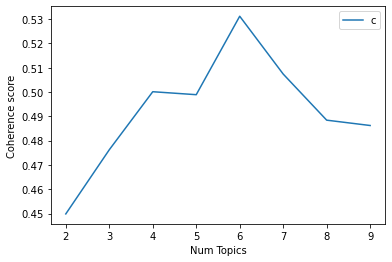

In [65]:
# Show graph

limit = 10; start = 2; step = 1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()


In [66]:
# Print the coherence scores

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4498
Num Topics = 3  has Coherence Value of 0.4762
Num Topics = 4  has Coherence Value of 0.5001
Num Topics = 5  has Coherence Value of 0.4989
Num Topics = 6  has Coherence Value of 0.5312
Num Topics = 7  has Coherence Value of 0.5074
Num Topics = 8  has Coherence Value of 0.4884
Num Topics = 9  has Coherence Value of 0.4862


## LDA Mallet Model

Code reference:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [187]:
mallet_path = '/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = 5, id2word = dictionary)

In [188]:
# Show Topics
pprint(ldamallet.show_topics(formatted = False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model = ldamallet, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

# The coherence score using the Mallet Model is lower than the original LDA Model

[(0,
  [('python', 0.23513021112420962),
   ('program', 0.11842246275854677),
   ('basic', 0.08252063015753938),
   ('start', 0.06665952202336298),
   ('knowledge', 0.03150787696924231),
   ('recommend', 0.021219590611938698),
   ('complete', 0.021219590611938698),
   ('introduction', 0.02089808166327296),
   ('cod', 0.01929053691994427),
   ('people', 0.013396206194405744)]),
 (1,
  [('experience', 0.05887939221272555),
   ('dr', 0.0587738735886884),
   ('lot', 0.04948823467341986),
   ('chuck', 0.047694418064788434),
   ('teacher', 0.04379022897541416),
   ('charles', 0.039886039886039885),
   ('coursera', 0.038303260525482746),
   ('amaze', 0.03798670465337132),
   ('professor', 0.0361928880447399),
   ('severance', 0.030811438218845626)]),
 (2,
  [('learn', 0.03872838355596976),
   ('make', 0.02982292637465051),
   ('class', 0.029512270891581236),
   ('assignment', 0.02858030444237341),
   ('thing', 0.023299161230195712),
   ('give', 0.022160091125608367),
   ('simple', 0.019467743

In [189]:
# Create new column with the topic

df['topic'] = ''

df['topic'] = [max(p, key = lambda item: item[1]) for p in lda_model[corpus]]

In [190]:
# Create two separate columns for the topic ID and topic score

df[['topic_id', 'topic_score']] = df['topic'].apply(pd.Series)

In [191]:
df

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined,topic,topic_id,topic_score
0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,0.9062,pos,"[course, beginner, enjoy, learn, dr, chuck, ma...",course beginner enjoy learn dr chuck make huge...,"(3, 0.39015016)",3.0,0.390150
1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos,0.9678,pos,"[super, easy, totally, beginner, course, title...",super easy totally beginner course title profe...,"(2, 0.47463694)",2.0,0.474637
2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67,pos,0.4703,pos,"[interactive, course, start, program, pyhton]",interactive course start program pyhton,"(3, 0.6914852)",3.0,0.691485
3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166,pos,0.9448,pos,"[awesome, course, definitely, introduction, co...",awesome course definitely introduction cod wor...,"(3, 0.748026)",3.0,0.748026
4,2021-03-11,Perfect for new learners,5,completer,24,pos,0.5719,pos,"[perfect, new, learner]",perfect new learner,"(0, 0.8054586)",0.0,0.805459
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8827,2020-07-21,excellent explanation starting with how comput...,5,dropout,129,pos,0.9080,pos,"[excellent, explanation, start, computer, gene...",excellent explanation start computer general w...,"(3, 0.49895638)",3.0,0.498956
8828,2020-07-21,My friend recommanded the lecture. It really d...,5,dropout,69,pos,0.5411,pos,"[friend, recommanded, lecture, deserve, five, ...",friend recommanded lecture deserve five star rate,"(0, 0.6513455)",0.0,0.651345
8829,2020-07-21,Highly recommend this sets a good foundation ...,5,dropout,56,pos,0.6901,pos,"[highly, recommend, set, foundation, python]",highly recommend set foundation python,"(3, 0.8729994)",3.0,0.872999
8830,2020-07-21,best python programming course for absolute be...,5,dropout,53,pos,0.6369,pos,"[best, python, program, course, absolute, begi...",best python program course absolute beginner,"(3, 0.8922712)",3.0,0.892271


In [192]:
df_final = df.drop(['status', 'joined', 'topic'], axis = 1)

In [193]:
df_final.head(31)

,date,review,rating,length,label,compound,sentiment,preprocessed,topic_id,topic_score
0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,135,pos,0.9062,pos,"[course, beginner, enjoy, learn, dr, chuck, ma...",3.0,0.390150
1,2021-03-11,Super easy and totally for the beginners like ...,5,163,pos,0.9678,pos,"[super, easy, totally, beginner, course, title...",2.0,0.474637
2,2021-03-11,Very interactive and a nice course to start pr...,5,67,pos,0.4703,pos,"[interactive, course, start, program, pyhton]",3.0,0.691485
3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,166,pos,0.9448,pos,"[awesome, course, definitely, introduction, co...",3.0,0.748026
4,2021-03-11,Perfect for new learners,5,24,pos,0.5719,pos,"[perfect, new, learner]",0.0,0.805459
5,2021-03-11,It's an amazing course for the beginners.It is...,5,208,pos,0.7906,pos,"[amaze, course, beginnersit, beginner, friendl...",3.0,0.806892
6,2021-03-11,\n\nGreat course and amazing teacher,5,36,pos,0.8360,pos,"[course, amaze, teacher]",2.0,0.806034
7,2021-03-11,Challenging and perfect course for a beginner...,4,262,pos,0.9403,pos,"[challenge, perfect, course, beginner, python,...",2.0,0.380412
8,2021-03-11,Good into to programming using this language,5,44,pos,0.4404,pos,"[program, use, language]",3.0,0.805510
9,2021-03-11,BEST AS BEST,5,12,pos,0.8555,pos,"[best, best]",3.0,0.749908
